In [1]:
# Check GPU type
!nvidia-smi

'nvidia-smi' is not recognized as an internal or external command,
operable program or batch file.


In [1]:
# Install ultralytics
!pip -q install ultralytics jupyter ipywidgets torch torchvision

In [2]:
# Import libraries
import pandas as pd
import os
from pathlib import Path
import shutil
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm
import cv2
import yaml
import matplotlib.pyplot as plt
from ultralytics import YOLO
import multiprocessing
import boto3
import torch
import torchvision.transforms as T
from PIL import Image
from sagemaker import get_execution_role

WARNING  Python>=3.10 is required, but Python==3.8.20 is currently installed 
sagemaker.config INFO - Not applying SDK defaults from location: C:\ProgramData\sagemaker\sagemaker\config.yaml
sagemaker.config INFO - Not applying SDK defaults from location: C:\Users\michael\AppData\Local\sagemaker\sagemaker\config.yaml


In [5]:
# get the session and execution role it may not work on local environments
session = boto3.Session()
region = session.region_name
# role = get_execution_role()

print(region)

us-east-1


In [6]:
# Create directories in standard python environment
os.makedirs('./dataset', exist_ok=True)
os.makedirs('./checkpoints', exist_ok=True)
os.makedirs('./images', exist_ok=True)
os.makedirs('./data', exist_ok=True)

In [7]:
# create the dataset in interactive jupyter notebooks
!mkdir ./dataset
!mkdir ./checkpoints
!mkdir ./images
!mkdir ./data

The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.
The syntax of the command is incorrect.


In [6]:
# download the data
!aws s3 cp s3://lmages/images/images.zip ./data

Completed 256.0 KiB/4.0 GiB (76.6 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/4.0 GiB (145.0 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/4.0 GiB (216.6 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/4.0 GiB (286.3 KiB/s) with 1 file(s) remaining  
Completed 1.2 MiB/4.0 GiB (357.9 KiB/s) with 1 file(s) remaining  
Completed 1.5 MiB/4.0 GiB (423.7 KiB/s) with 1 file(s) remaining  
Completed 1.8 MiB/4.0 GiB (494.3 KiB/s) with 1 file(s) remaining  
Completed 2.0 MiB/4.0 GiB (550.7 KiB/s) with 1 file(s) remaining  
Completed 2.2 MiB/4.0 GiB (617.0 KiB/s) with 1 file(s) remaining  
Completed 2.5 MiB/4.0 GiB (685.5 KiB/s) with 1 file(s) remaining  
Completed 2.8 MiB/4.0 GiB (754.1 KiB/s) with 1 file(s) remaining  
Completed 3.0 MiB/4.0 GiB (819.2 KiB/s) with 1 file(s) remaining  
Completed 3.2 MiB/4.0 GiB (887.5 KiB/s) with 1 file(s) remaining  
Completed 3.5 MiB/4.0 GiB (951.8 KiB/s) with 1 file(s) remaining  
Completed 3.8 MiB/4.0 GiB (1019.8 KiB/s) with 1 file(s) remaini

In [13]:
# Set up directories for training a yolo model
DATA_DIR = Path('data')

# Images directories
DATASET_DIR = Path('dataset')
IMAGES_DIR =  DATASET_DIR / 'images'
TRAIN_IMAGES_DIR = IMAGES_DIR / 'train'
VAL_IMAGES_DIR = IMAGES_DIR / 'val'
TEST_IMAGES_DIR = IMAGES_DIR / 'test'

# Labels directories
LABELS_DIR = DATASET_DIR / 'labels'
TRAIN_LABELS_DIR = LABELS_DIR / 'train'
VAL_LABELS_DIR = LABELS_DIR / 'val'
TEST_LABELS_DIR = LABELS_DIR / 'test'

In [4]:
# Unzip images to 'images' dir
shutil.unpack_archive(DATA_DIR/ 'images.zip', 'images')

In [11]:
# get the training, test and submission sets
!aws s3 cp s3://lmages/Train.csv ./data
!aws s3 cp s3://lmages/Test.csv ./data
!aws s3 cp s3://lmages/SampleSubmission.csv ./data

Completed 256.0 KiB/1.1 MiB (147.9 KiB/s) with 1 file(s) remaining
Completed 512.0 KiB/1.1 MiB (266.5 KiB/s) with 1 file(s) remaining
Completed 768.0 KiB/1.1 MiB (363.7 KiB/s) with 1 file(s) remaining
Completed 1.0 MiB/1.1 MiB (484.9 KiB/s) with 1 file(s) remaining  
Completed 1.1 MiB/1.1 MiB (530.7 KiB/s) with 1 file(s) remaining  
download: s3://lmages/Train.csv to data\Train.csv                 
Completed 27.7 KiB/27.7 KiB (21.4 KiB/s) with 1 file(s) remaining
download: s3://lmages/Test.csv to data\Test.csv                  
Completed 154.2 KiB/154.2 KiB (94.9 KiB/s) with 1 file(s) remaining
download: s3://lmages/SampleSubmission.csv to data\SampleSubmission.csv


In [18]:
# Load train and test files
train = pd.read_csv(DATA_DIR / 'Train.csv')
test = pd.read_csv(DATA_DIR / 'Test.csv')
ss = pd.read_csv(DATA_DIR / 'SampleSubmission.csv')

# Add an image_path column
train['image_path'] = [Path('images/' + x) for x in train.Image_ID]
test['image_path'] = [Path('images/' + x) for x in test.Image_ID]

# Map str classes to ints (label encoding targets)
train['class_id'] = train['class'].map({'Trophozoite': 0, 'WBC': 1, 'NEG': 2})

# Preview the head of the train set
train.head(20)

Image_ID        class  confidence  ymin  xmin  ymax  xmax  \
0   id_u3q6jdck4j.jpg  Trophozoite         1.0   712  1241   737  1270   
1   id_a6cl90trri.jpg  Trophozoite         1.0   558  1566   600  1604   
2   id_qvc2le9sm8.jpg  Trophozoite         1.0  1317  2788  1448  2914   
3   id_w8xnbd5rvm.jpg  Trophozoite         1.0   925  1744  1041  1823   
4   id_6dop09rk02.jpg          NEG         1.0     0     0     0     0   
5   id_i7r9hkhxvx.jpg          WBC         1.0   846   906   903   963   
6   id_fzogq9kijh.jpg          WBC         1.0   641   280   711   373   
7   id_i8qcpi8ey9.jpg  Trophozoite         1.0   501  1141   532  1170   
8   id_y0me081u0v.jpg          NEG         1.0     0     0     0     0   
9   id_2phbgf1x5m.jpg  Trophozoite         1.0   687  1169   725  1205   
10  id_8l8zssuabc.jpg  Trophozoite         1.0  1807  1992  1897  2082   
11  id_i4d0ulpq39.jpg          WBC         1.0   799   838   863   906   
12  id_pwiv4czvne.jpg  Trophozoite         1.0   391  3002   513  3087   
13  id_8y0uii4k60.jpg  Trophozoite         1.0  1950  2315  2077  2410   
14  id_ylrsd2a6k4.jpg  Trophozoite         1.0    25   923    59   957   
15  id_n0dqkovtp3.jpg  Trophozoite         1.0   229   637   263   673   
16  id_5bbz3srksa.jpg  Trophozoite         1.0   673  1455   713  1495   
17  id_e3tep47339.jpg  Trophozoite         1.0   679   794   711   822   
18  id_ytq3slqkjm.jpg  Trophozoite         1.0   108   768   148   800   
19  id_nzkpf8tr8o.jpg          WBC         1.0   479  1091   549  1169   

                  image_path  class_id  
0   images\id_u3q6jdck4j.jpg         0  
1   images\id_a6cl90trri.jpg         0  
2   images\id_qvc2le9sm8.jpg         0  
3   images\id_w8xnbd5rvm.jpg         0  
4   images\id_6dop09rk02.jpg         2  
5   images\id_i7r9hkhxvx.jpg         1  
6   images\id_fzogq9kijh.jpg         1  
7   images\id_i8qcpi8ey9.jpg         0  
8   images\id_y0me081u0v.jpg         2  
9   images\id_2phbgf1x5m.jpg         0  
10  images\id_8l8zssuabc.jpg         0  
11  images\id_i4d0ulpq39.jpg         1  
12  images\id_pwiv4czvne.jpg         0  
13  images\id_8y0uii4k60.jpg         0  
14  images\id_ylrsd2a6k4.jpg         0  
15  images\id_n0dqkovtp3.jpg         0  
16  images\id_5bbz3srksa.jpg         0  
17  images\id_e3tep47339.jpg         0  
18  images\id_ytq3slqkjm.jpg         0  
19  images\id_nzkpf8tr8o.jpg         1

In [15]:
"""
Filter out NEG class (Negative images - these images have no Trophozoite nor WBC in them)
# Yolo recommends that when creating labels for negative images, you leave them empty
# https://github.com/ultralytics/yolov5/issues/3218
# As this is a starter nb, we will ignore the negative images
"""
train = train[~(train['class'] == 'NEG')].reset_index(drop = True)

In [60]:
import numpy as np

# transform the images using torchvision

# Define the transformation pipeline
transform = T.Compose([
    T.Resize((416, 416)),                         # Resize to YOLO input size
    T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),  # Random color jitter for augmentation
    T.RandomHorizontalFlip(p=0.5),
    T.RandomRotation(60),
    T.ToTensor(),                                 # Convert to tensor and scale [0, 255] to [0, 1]
    T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize with ImageNet values (optional)
])

# Function to apply the transformation pipeline to an image and save the images

def save_transformed_images(train_set, output_dir, num_images=5):
    """
    Apply transformations to an image multiple times and save each result as a new image.
    
    Args:
    - train_set: object, train data set.
    - output_dir: str, directory where transformed images will be saved.
    - num_images: int, number of transformed images to generate.
    """
    for index, row in train_set.iterrows():
        # obtain row data 
        data = row.to_dict()
        
        # Ensure output directory exists
        os.makedirs(output_dir, exist_ok=True)

        # Load the original image
        original_image = Image.open(data['image_path']).convert("RGB")
        for i in range(num_images):
            # Apply transformations
            transformed_image = transform(original_image)

            # Convert to a format compatible with saving (PIL Image)
            transformed_image_pil = T.ToPILImage()(transformed_image)
            
            # generate the file name and a random number for uniqueness
            file_name, file_extension = os.path.splitext(data['image_path'])
            real_file_name = file_name.split('\\')[-1]
        
            # Save the transformed image
            output_path = os.path.join(output_dir, f"{real_file_name}_{np.random.randint(1, 1000)}.jpg")
            transformed_image_pil.save(output_path)
            print(f"Saved {output_path}")
            
            # save the data to train set 
            new_image = pd.DataFrame(
            {
                'Image_ID': real_file_name,
                'class': data['class'],
                'confidence': data['confidence'],
                'ymin': data['ymin'],
                'xmin': data['xmin'],
                'ymax': data['ymax'],
                'xmax': data['xmax'],
                'image_path': output_path,
                'class_id': data['class_id']   
            },
            index=[0]
            )
            
            train_set = pd.concat([train_set, new_image], ignore_index=True)



In [61]:
# Generate transformed images to increase the training space
save_transformed_images(train, 'images', num_images=5)

Saved images\id_u3q6jdck4j_270.jpg
Saved images\id_u3q6jdck4j_427.jpg
Saved images\id_u3q6jdck4j_40.jpg
Saved images\id_u3q6jdck4j_948.jpg
Saved images\id_u3q6jdck4j_937.jpg
Saved images\id_a6cl90trri_156.jpg
Saved images\id_a6cl90trri_208.jpg
Saved images\id_a6cl90trri_846.jpg
Saved images\id_a6cl90trri_424.jpg
Saved images\id_a6cl90trri_52.jpg
Saved images\id_qvc2le9sm8_209.jpg
Saved images\id_qvc2le9sm8_331.jpg
Saved images\id_qvc2le9sm8_173.jpg
Saved images\id_qvc2le9sm8_25.jpg
Saved images\id_qvc2le9sm8_185.jpg
Saved images\id_w8xnbd5rvm_557.jpg
Saved images\id_w8xnbd5rvm_850.jpg
Saved images\id_w8xnbd5rvm_167.jpg
Saved images\id_w8xnbd5rvm_313.jpg
Saved images\id_w8xnbd5rvm_396.jpg
Saved images\id_6dop09rk02_90.jpg
Saved images\id_6dop09rk02_69.jpg
Saved images\id_6dop09rk02_485.jpg
Saved images\id_6dop09rk02_407.jpg
Saved images\id_6dop09rk02_580.jpg
Saved images\id_i7r9hkhxvx_170.jpg
Saved images\id_i7r9hkhxvx_749.jpg
Saved images\id_i7r9hkhxvx_248.jpg
Saved images\id_i7r9hkhxv

KeyboardInterrupt: 

In [13]:
# Split data into training and validation
train_unique_imgs_df = train.drop_duplicates(subset = ['Image_ID'], ignore_index = True)
X_train, X_val = train_test_split(train_unique_imgs_df, test_size = 0.25, stratify=train_unique_imgs_df['class'], random_state=42)

X_train = train[train.Image_ID.isin(X_train.Image_ID)]
X_val = train[train.Image_ID.isin(X_val.Image_ID)]

# Check shapes of training and validation data
X_train.shape, X_val.shape

((17354, 9), (5488, 9))

In [14]:
# Preview target distribution, seems there a class imbalance that needs to be handled
X_train['class'].value_counts(normalize = True), X_val['class'].value_counts(normalize = True)

(class
 Trophozoite    0.688141
 WBC            0.311859
 Name: proportion, dtype: float64,
 class
 Trophozoite    0.709913
 WBC            0.290087
 Name: proportion, dtype: float64)

In [ ]:
%%sql


In [16]:
# Check if dirs exist, if they do, remove them, otherwise create them.
# This only needs to run once
for DIR in [TRAIN_IMAGES_DIR,VAL_IMAGES_DIR, TEST_IMAGES_DIR, TRAIN_LABELS_DIR,VAL_LABELS_DIR,TEST_LABELS_DIR]:
  if DIR.exists():
    shutil.rmtree(DIR)
  DIR.mkdir(parents=True, exist_ok = True)

In [17]:
# Copy train, val and test images to their respective dirs
for img in tqdm(X_train.image_path.unique()):
  shutil.copy(img, TRAIN_IMAGES_DIR / img.parts[-1])

for img in tqdm(X_val.image_path.unique()):
  shutil.copy(img, VAL_IMAGES_DIR / img.parts[-1])

for img in tqdm(test.image_path.unique()):
  shutil.copy(img, TEST_IMAGES_DIR / img.parts[-1])

  0%|          | 0/1544 [00:00<?, ?it/s]

  0%|          | 0/515 [00:00<?, ?it/s]

  0%|          | 0/1178 [00:00<?, ?it/s]

In [ ]:
# Function to convert the boxes to yolo format and save them
def save_yolo_annotation(row):
    image_path, class_id, output_dir = row['image_path'], row['class_id'], row['output_dir']

    # convert POSIX path to str path
    if isinstance(image_path, Path):
        image_path = str(image_path)

    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image from path: {image_path}")

    height, width, _ = img.shape

    label_file = Path(output_dir) / f"{Path(image_path).stem}.txt"

    ymin, xmin, ymax, xmax = row['ymin'], row['xmin'], row['ymax'], row['xmax']

    # Normalize the coordinates
    x_center = (xmin + xmax) / 2 / width
    y_center = (ymin + ymax) / 2 / height
    bbox_width = (xmax - xmin) / width
    bbox_height = (ymax - ymin) / height

    with open(label_file, 'a') as f:
        f.write(f"{class_id} {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}\n")


# Parallelize the annotation saving process
def process_dataset(dataframe, output_dir):
    dataframe['output_dir'] = output_dir
    with multiprocessing.Pool() as pool:
        list(tqdm(pool.imap(save_yolo_annotation, dataframe.to_dict('records')), total=len(dataframe)))


# Save train and validation labels to their respective dirs
process_dataset(X_train, TRAIN_LABELS_DIR)
process_dataset(X_val, VAL_LABELS_DIR)

C:\Users\michael\AppData\Local\Temp\ipykernel_11360\2393866048.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataframe['output_dir'] = output_dir


  0%|          | 0/17354 [00:00<?, ?it/s]

In [15]:
# Train images dir
TRAIN_IMAGES_DIR

PosixPath('dataset/images/train')

In [16]:
# Create a data.yaml file required by yolo
class_names = train['class'].unique().tolist()
num_classes = len(class_names)

data_yaml = {
    'train': '/home/sagemaker-user/lacuna-Malaraia-Detection/'
    + str(TRAIN_IMAGES_DIR),
    'val':  '/home/sagemaker-user/lacuna-Malaraia-Detection/'
    + str(VAL_IMAGES_DIR),
    'test': '/home/sagemaker-user/lacuna-Malaraia-Detection/'
    + str(TEST_IMAGES_DIR),
    'nc': num_classes,
    'names': class_names
}

yaml_path = 'data.yaml'
with open(yaml_path, 'w') as file:
    yaml.dump(data_yaml, file, default_flow_style=False)

# Preview data yaml file
data_yaml

{'train': '/home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/train',
 'val': '/home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/val',
 'test': '/home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/test',
 'nc': 2,
 'names': ['Trophozoite', 'WBC']}

Plotting id_u3q6jdck4j.jpg with 4 bounding boxes.


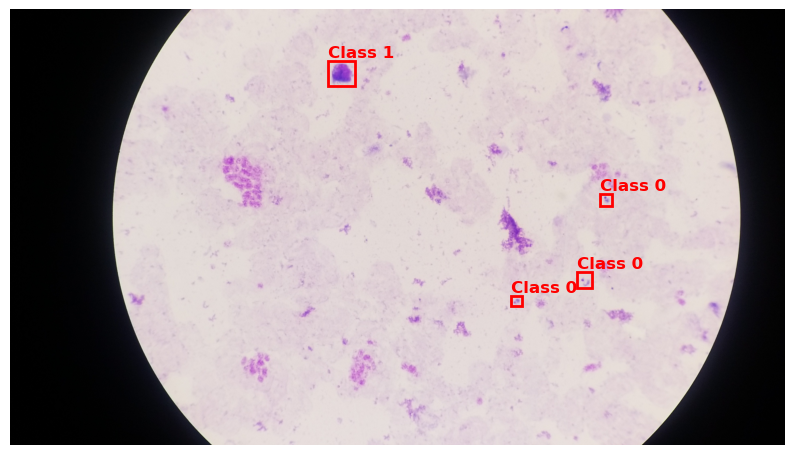

Plotting id_qvc2le9sm8.jpg with 6 bounding boxes.


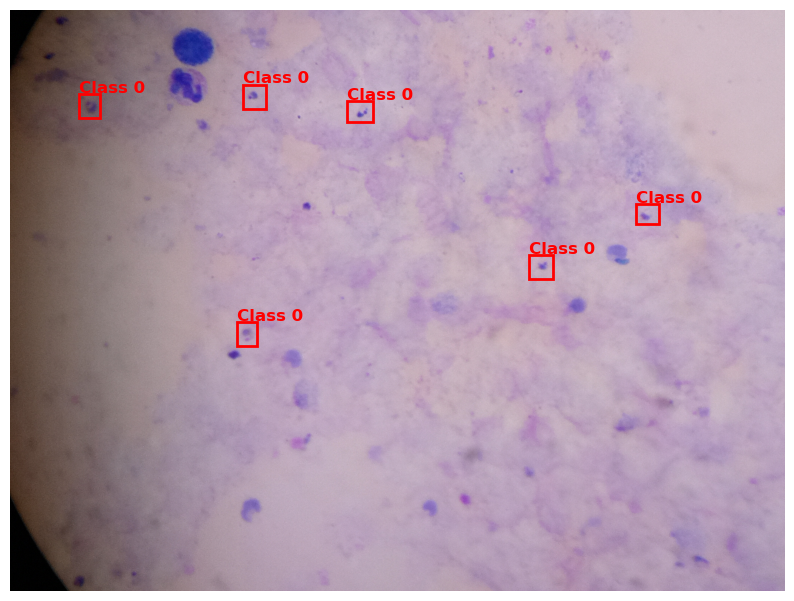

Plotting id_w8xnbd5rvm.jpg with 21 bounding boxes.


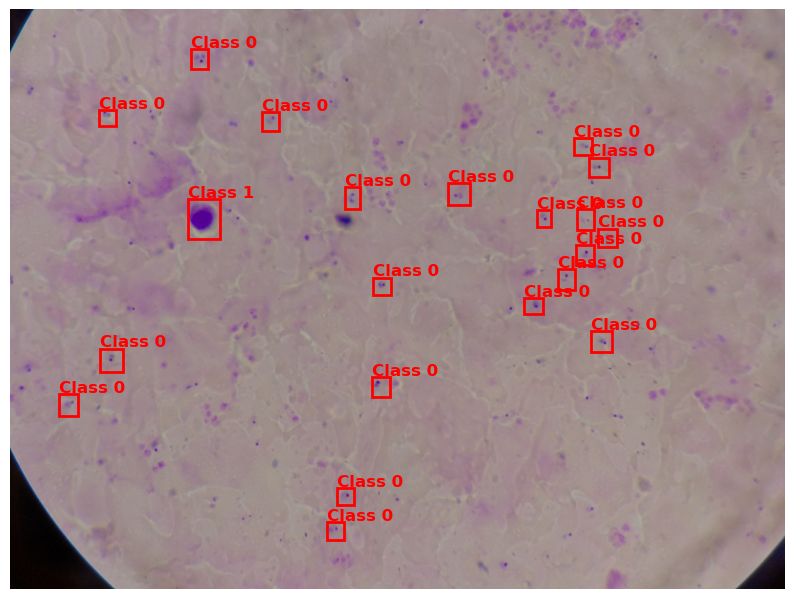

In [17]:
# Plot some images and their boxes to ensure the conversion was done correctly
def load_annotations(label_path):
    with open(label_path, 'r') as f:
        lines = f.readlines()
    boxes = []
    for line in lines:
        class_id, x_center, y_center, width, height = map(float, line.strip().split())
        boxes.append((class_id, x_center, y_center, width, height))
    return boxes

# Function to plot an image with its bounding boxes
def plot_image_with_boxes(image_path, boxes):
    # Load the image
    image = cv2.imread(str(image_path))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Get image dimensions
    h, w, _ = image.shape

    # Plot the image
    plt.figure(figsize=(10, 10))
    plt.imshow(image)

    # Plot each bounding box
    for box in boxes:
        class_id, x_center, y_center, width, height = box
        # Convert YOLO format to corner coordinates
        xmin = int((x_center - width / 2) * w)
        ymin = int((y_center - height / 2) * h)
        xmax = int((x_center + width / 2) * w)
        ymax = int((y_center + height / 2) * h)

        # Draw the bounding box
        plt.gca().add_patch(plt.Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                                          edgecolor='red', facecolor='none', linewidth=2))
        plt.text(xmin, ymin - 10, f'Class {int(class_id)}', color='red', fontsize=12, weight='bold')

    plt.axis('off')
    plt.show()

# Directories for images and labels
IMAGE_DIR = TRAIN_IMAGES_DIR
LABEL_DIR = TRAIN_LABELS_DIR

# Plot a few images with their annotations
for image_name in os.listdir(IMAGE_DIR)[:3]:
    image_path = IMAGE_DIR / image_name
    label_path = LABEL_DIR / (image_name.replace('.jpg', '.txt').replace('.png', '.txt'))

    if label_path.exists():
        boxes = load_annotations(label_path)
        print(f"Plotting {image_name} with {len(boxes)} bounding boxes.")
        plot_image_with_boxes(image_path, boxes)
    else:
        print(f"No annotations found for {image_name}.")


In [ ]:
# Load a yolo pre-trained model

model = YOLO('yolo11m.pt')
# Fine tune model to our data
model.train(
    data='data.yaml',          # Path to the dataset configuration
    epochs=30,                 # Number of epochs
    imgsz=1024,                # Image size (height, width)
    batch=4,                   # Batch size
    device=0,                  # Device to use (0 for the first GPU)
    patience=5)


Ultralytics 8.3.19 🚀 Python-3.11.9 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14931MiB)
engine/trainer: task=detect, mode=train, model=yolo11m.pt, data=data.yaml, epochs=30, time=None, patience=5, batch=4, imgsz=1024, save=True, save_period=-1, cache=False, device=0, workers=8, project=None, name=train13, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_width=N

train: Scanning /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/labels/train.cache... 1544 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1544/1544 [00:00<?, ?it/s]
val: Scanning /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/labels/val.cache... 515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:00<?, ?it/s]


Plotting labels to runs/detect/train13/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.001667, momentum=0.9) with parameter groups 106 weight(decay=0.0), 113 weight(decay=0.0005), 112 bias(decay=0.0)


2024/10/22 11:59:34 WARNING mlflow.tracking.fluent: Exception raised while enabling autologging for tensorflow: No module named 'tensorflow.keras'
2024/10/22 11:59:34 WARNING mlflow.utils.autologging_utils: You are using an unsupported version of keras. If you encounter errors during autologging, try upgrading / downgrading keras to a supported version, or try upgrading MLflow.
2024/10/22 11:59:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for keras.
2024/10/22 11:59:34 INFO mlflow.tracking.fluent: Autologging successfully enabled for sklearn.
2024/10/22 11:59:35 INFO mlflow.tracking.fluent: Autologging successfully enabled for statsmodels.


MLflow: logging run_id(8b555d550d854b66ae2bb36a0ffb5466) to runs/mlflow
MLflow: view at http://127.0.0.1:5000 with 'mlflow server --backend-store-uri runs/mlflow'
MLflow: disable with 'yolo settings mlflow=False'
TensorBoard: model graph visualization added ✅
Image sizes 1024 train, 1024 val
Using 8 dataloader workers
Logging results to runs/detect/train13
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      6.22G      1.941      1.658      1.172         53       1024: 100%|██████████| 386/386 [02:05<00:00,  3.07it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.69it/s]


                   all        515       5488      0.515      0.662      0.595      0.257

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      6.22G      1.898      1.392      1.178         71       1024: 100%|██████████| 386/386 [02:02<00:00,  3.15it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.77it/s]

                   all        515       5488      0.593      0.753      0.745      0.363



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      6.11G      1.901      1.381      1.183         98       1024: 100%|██████████| 386/386 [02:02<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488       0.54      0.603      0.599      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      6.05G      1.864      1.336      1.162         61       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.78it/s]

                   all        515       5488      0.678      0.732      0.724      0.342



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      6.07G      1.839      1.281      1.153         27       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.78it/s]

                   all        515       5488      0.553      0.687        0.6      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      6.06G      1.787       1.18      1.132         65       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488      0.753       0.78      0.796      0.399



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      6.06G       1.79      1.159      1.136         79       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.76it/s]

                   all        515       5488      0.674      0.797      0.787      0.397



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      6.05G      1.784      1.128      1.126         91       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.78it/s]

                   all        515       5488      0.749      0.742      0.776      0.394



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      6.01G      1.783      1.124      1.126         65       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.756      0.775      0.803      0.412



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      6.06G      1.767      1.097      1.118         87       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.83it/s]

                   all        515       5488      0.737      0.697      0.745      0.381



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      6.24G      1.771        1.1      1.123         42       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488      0.751      0.739      0.775      0.385



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      6.06G      1.761      1.081       1.12         50       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.767      0.807       0.82      0.422



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      6.08G      1.759      1.071      1.113         71       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.785      0.788      0.821      0.424



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      6.06G       1.74      1.044      1.108        100       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.78it/s]

                   all        515       5488       0.77      0.807      0.818      0.419



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      6.07G      1.743      1.031      1.106         77       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488      0.782       0.75       0.81       0.42



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      6.04G      1.742      1.021      1.106         45       1024: 100%|██████████| 386/386 [02:01<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488      0.777      0.824      0.838      0.434


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      6.08G      1.743      1.042      1.149         27       1024: 100%|██████████| 386/386 [02:01<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.78it/s]

                   all        515       5488      0.777       0.82      0.833       0.43



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      6.02G      1.745       1.03      1.156        130       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.765      0.823       0.84      0.436



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      6.05G      1.743       1.01      1.153         43       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.78it/s]

                   all        515       5488      0.796      0.826      0.844      0.442



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      6.06G      1.723     0.9902      1.147         33       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488      0.778      0.834      0.852      0.445



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      6.06G      1.729     0.9772      1.155         15       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488      0.779      0.832      0.852      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      6.06G      1.725     0.9743      1.147         40       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.795      0.829      0.856      0.447



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      6.05G      1.715     0.9547      1.136         42       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.802      0.825      0.854      0.452



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      6.06G      1.708     0.9552      1.133         34       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.804      0.838      0.863      0.458



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      6.07G      1.703     0.9377      1.141         28       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.80it/s]

                   all        515       5488        0.8       0.84      0.864      0.456



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      6.05G      1.693     0.9251      1.124         31       1024: 100%|██████████| 386/386 [02:00<00:00,  3.19it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:11<00:00,  5.79it/s]

                   all        515       5488      0.806      0.839      0.864      0.457



30 epochs completed in 1.123 hours.
Optimizer stripped from runs/detect/train13/weights/last.pt, 40.6MB
Optimizer stripped from runs/detect/train13/weights/best.pt, 40.6MB

Validating runs/detect/train13/weights/best.pt...
Ultralytics 8.3.19 🚀 Python-3.11.9 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14931MiB)
YOLO11m summary (fused): 303 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 65/65 [00:10<00:00,  5.95it/s]


                   all        515       5488      0.803      0.838      0.863      0.458
           Trophozoite        507       3896      0.701      0.707      0.744      0.303
                   WBC        392       1592      0.906       0.97      0.982      0.613
Speed: 0.5ms preprocess, 16.4ms inference, 0.0ms loss, 0.8ms postprocess per image
Results saved to runs/detect/train13
MLflow: results logged to runs/mlflow
MLflow: disable with 'yolo settings mlflow=False'


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x7fe9f4819990>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
          0.04804

In [20]:
# Validate the model on the validation set
model = YOLO('/home/sagemaker-user/lacuna-Malaraia-Detection/runs/detect/train13/weights/best.pt')
results = model.val()

Ultralytics 8.3.19 🚀 Python-3.11.9 torch-2.3.1.post300 CUDA:0 (Tesla T4, 14931MiB)
YOLO11m summary (fused): 303 layers, 20,031,574 parameters, 0 gradients, 67.7 GFLOPs


val: Scanning /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/labels/val.cache... 515 images, 0 backgrounds, 0 corrupt: 100%|██████████| 515/515 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 33/33 [00:22<00:00,  1.47it/s]


                   all        515       5488      0.803      0.837      0.863      0.459
           Trophozoite        507       3896      0.701      0.705      0.745      0.303
                   WBC        392       1592      0.906      0.969      0.982      0.614
Speed: 0.6ms preprocess, 37.9ms inference, 0.0ms loss, 0.9ms postprocess per image
Results saved to runs/detect/val


In [ ]:
# Load the trained YOLO model
model = YOLO('/home/sagemaker-user/lacuna-Malaraia-Detection/runs/detect/train13/weights/best.pt')

test_set = '/home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/test'

# Path to the test images directory
test_dir_path = test_set

# Get a list of all image files in the test directory
image_files = os.listdir(test_dir_path)

# Initialize an empty list to store the results for all images
all_data = []

# Iterate through each image in the directory
for image_file in tqdm(image_files):
    # Full path to the image
    img_path = os.path.join(test_dir_path, image_file)

    # Make predictions on the image
    results = model(img_path)

    # Extract bounding boxes, confidence scores, and class labels
    boxes = results[0].boxes.xyxy.tolist()  # Bounding boxes in xyxy format
    classes = results[0].boxes.cls.tolist()  # Class indices
    confidences = results[0].boxes.conf.tolist()  # Confidence scores
    names = results[0].names  # Class names dictionary

    if not boxes:
        # If no detections, add NEG as the class
        all_data.append({
            'Image_ID': image_file,
            'class': 'NEG',
            'confidence': 1.0,  # You can set this to a default value
            'ymin': 0,  # Default value (no detection)
            'xmin': 0,  # Default value (no detection)
            'ymax': 0,  # Default value (no detection)
            'xmax': 0   # Default value (no detection)
        })
    else:
        # Iterate through the results for this image
        for box, cls, conf in zip(boxes, classes, confidences):
            x1, y1, x2, y2 = box
            detected_class = names[int(cls)]  # Get the class name from the names dictionary

            # Add the result to the all_data list
            all_data.append({
                'Image_ID': image_file,
                'class': detected_class,
                'confidence': conf,
                'ymin': y1,
                'xmin': x1,
                'ymax': y2,
                'xmax': x2
            })

# Convert the list to a DataFrame for all images
sub = pd.DataFrame(all_data)

  0%|          | 0/1178 [00:00<?, ?it/s]


image 1/1 /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/test/id_5n9ov0rr22.jpg: 768x1024 11 Trophozoites, 2 WBCs, 68.9ms
Speed: 7.3ms preprocess, 68.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/test/id_k6s11k3klo.jpg: 768x1024 4 Trophozoites, 55.3ms
Speed: 7.1ms preprocess, 55.3ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/test/id_eftvcf9djb.jpg: 768x1024 6 Trophozoites, 5 WBCs, 54.4ms
Speed: 7.3ms preprocess, 54.4ms inference, 1.3ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/test/id_kc5tmoj1xa.jpg: 768x1024 2 Trophozoites, 51.9ms
Speed: 7.4ms preprocess, 51.9ms inference, 1.2ms postprocess per image at shape (1, 3, 768, 1024)

image 1/1 /home/sagemaker-user/lacuna-Malaraia-Detection/dataset/images/te

In [ ]:
sub.head()

In [ ]:
sub['class'].value_counts()

In [ ]:
# Create submission file to be uploaded to Zindi for scoring
sub.to_csv('benchmark_submission.csv', index = False)